In [1]:
import numpy as np
import random
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Activation, Dropout
from tensorflow.keras.optimizers.legacy import RMSprop
import matplotlib.pyplot as plt

In [2]:
train_data_URL = './data/shakespeare_train.txt'
val_data_URL = './data/shakespeare_valid.txt'

with open(train_data_URL, 'r', encoding='UTF-8') as f:
    train_text = f.read()

with open(val_data_URL, 'r', encoding='UTF-8') as f:
    valid_text = f.read()

In [ ]:
train_text = train_text[100000:800000]
valid_text = valid_text[100000:800000]

In [4]:
vocab = sorted(set(train_text))
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [ ]:
SEQ_LENGTH = 20
STEP_SIZE = 1
BATCH_SIZE = 256
HIDDEN_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 10

In [6]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [7]:
train_sentences = []
train_next_characters = []
for i in range(0, len(train_text) - SEQ_LENGTH, STEP_SIZE):
    train_sentences.append(train_text[i: i + SEQ_LENGTH])
    train_next_characters.append(train_text[i + SEQ_LENGTH])

valid_sentences = []
valid_next_characters = []
for i in range(0, len(valid_text) - SEQ_LENGTH, STEP_SIZE):
    valid_sentences.append(valid_text[i: i + SEQ_LENGTH])
    valid_next_characters.append(valid_text[i + SEQ_LENGTH])

In [11]:
x_train = np.zeros((len(train_sentences), SEQ_LENGTH, vocab_size), dtype=np.bool)
y_train = np.zeros((len(train_sentences), vocab_size), dtype=np.bool)
for i, sentence in enumerate(train_sentences):
    for t, char in enumerate(sentence):
        x_train[i, t, char_to_idx[char]] = 1
    y_train[i, char_to_idx[train_next_characters[i]]] = 1

x_valid = np.zeros((len(valid_sentences), SEQ_LENGTH, vocab_size), dtype=np.bool)
y_valid = np.zeros((len(valid_sentences), vocab_size), dtype=np.bool)
for i, sentence in enumerate(valid_sentences):
    for t, char in enumerate(sentence):
        x_valid[i, t, char_to_idx[char]] = 1
    y_valid[i, char_to_idx[valid_next_characters[i]]] = 1


/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_91269/2111268552.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.zeros((len(train_sentences), SEQ_LENGTH, vocab_size), dtype=np.bool)
/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_91269/2111268552.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np

In [ ]:
model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=(SEQ_LENGTH, vocab_size)))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=LEARNING_RATE))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               99328     
                                                                 
 dense (Dense)               (None, 65)                8385      
                                                                 
 activation (Activation)     (None, 65)                0         
                                                                 
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


2024-11-26 23:53:06.036069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-26 23:53:06.036870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-26 23:53:06.037439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
def generate_text(num_lines, temperature):
    start_index = random.randint(0, len(train_text) - SEQ_LENGTH - 1)
    generated = ''
    sentence = train_text[start_index:start_index + SEQ_LENGTH]
    generated += sentence
    lines_generated = sentence.count('\n')

    while lines_generated < num_lines:
        x_predictions = np.zeros((1, SEQ_LENGTH, vocab_size))
        for t, char in enumerate(sentence):
            x_predictions[0, t, char_to_idx[char]] = 1

        predictions = model.predict(x_predictions, verbose=0)[0]
        next_index = sample(predictions, temperature)
        next_character = idx_to_char[next_index]

        generated += next_character
        sentence = sentence[1:] + next_character

        if next_character == '\n':
            lines_generated += 1

    return generated

In [12]:
print(len(train_text), len(valid_text))

700000 122025


In [ ]:
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                        batch_size=BATCH_SIZE, epochs=1, verbose=2)
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    if (epoch + 1) in [1, 3, 5, 7, 10]:
        print(f"\nGenerated text after epoch {epoch + 1}:")
        print(generate_text(5, temperature=0.5))

Epoch 1/10


2024-11-26 23:53:13.194635: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-26 23:53:13.341135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-26 23:53:13.341696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-26 23:53:13.342330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

2735/2735 - 97s - loss: 1.7783 - val_loss: 1.7546 - 97s/epoch - 35ms/step

Generated text after epoch 1:


2024-11-26 23:54:50.130000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-26 23:54:50.130753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-26 23:54:50.131330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

nd he squeak'd out and country my dears for the sea to for such distroke.

CAMILLO:
But we warks of monthing and be to better of mine
And make fear, to he do the fall of thine.

Epoch 2/10
2735/2735 - 108s - loss: 1.5218 - val_loss: 1.6862 - 108s/epoch - 40ms/step
Epoch 3/10
2735/2735 - 111s - loss: 1.4694 - val_loss: 1.6799 - 111s/epoch - 40ms/step

Generated text after epoch 3:
ou do not, make the sword and for the confent
When he be remember she while their soul of exceltion;
There in the false fear!

First Murderer:

Epoch 4/10
2735/2735 - 120s - loss: 1.4418 - val_loss: 1.6763 - 120s/epoch - 44ms/step
Epoch 5/10
2735/2735 - 113s - loss: 1.4254 - val_loss: 1.6528 - 113s/epoch - 41ms/step

Generated text after epoch 5:
s:
As a long-parted be so man.

Second Murderer:
What save I with him and some man's hearts of me.

Epoch 6/10
2735/2735 - 112s - loss: 1.4129 - val_loss: 1.6636 - 112s/epoch - 41ms/step
Epoch 7/10
2735/2735 - 113s - loss: 1.4038 - val_loss: 1.6911 - 113s/epoch - 41ms

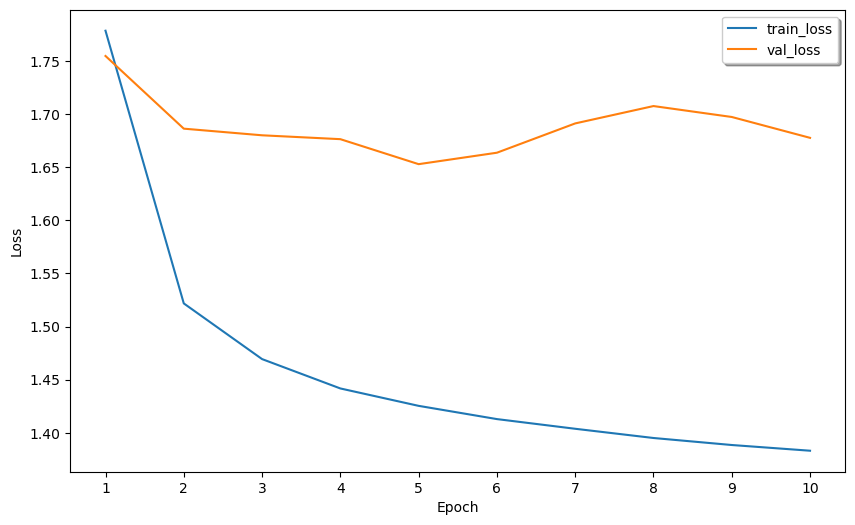

Training error rate = 
1.383192777633667
Validation error rate = 
1.6775511503219604


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(range(1, len(train_loss) + 1))
plt.legend(loc='upper right', shadow=True)
plt.show()

print("Training error rate = ")
print(train_loss[-1])
print("Validation error rate = ")
print(val_loss[-1])

In [15]:
start_text = "JULIET"
num_lines = 10

generated = generate_text(num_lines=num_lines, temperature=0.3)
print(f"Generated text (primed with '{start_text}'):\n{generated}")

Generated text (primed with 'JULIET'):
G HENRY VI

KING EDWARD IV:
What, shall stand the country in the man is here heard the field
As that with the sad counter'd to the seat to the ground.

Second Murderer:
What shall show his world, and show the man is the sea to the body,
The true than the death, the seat and the day is the consent to the heart
That he sease to a bad from the consent of the seat to the sears,



2024-11-27 00:13:44.534070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-27 00:13:44.534853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-27 00:13:44.535284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

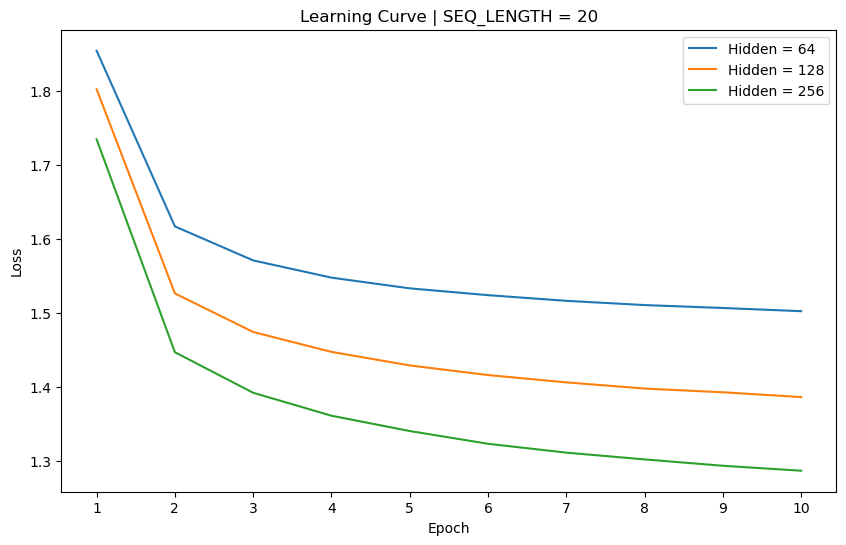

In [16]:
hidden_sizes = [64, 128, 256]
results_hidden = {}

for hidden_size in hidden_sizes:
    model = Sequential()
    model.add(LSTM(hidden_size, input_shape=(SEQ_LENGTH, vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=LEARNING_RATE)
)  
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    results_hidden[hidden_size] = history.history['loss']

plt.figure(figsize=(10, 6))
for hidden_size, loss in results_hidden.items():
    plt.plot(range(1, EPOCHS + 1), loss, label=f"Hidden = {hidden_size}")
plt.title("Learning Curve | SEQ_LENGTH = 20")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.show()

In [17]:
def process_data(text, seq_length):
    sentences = []
    next_characters = []
    for i in range(0, len(text) - seq_length, STEP_SIZE):
        sentences.append(text[i: i + seq_length])
        next_characters.append(text[i + seq_length])
    
    x = np.zeros((len(sentences), seq_length, vocab_size), dtype=np.bool)
    y = np.zeros((len(sentences), vocab_size), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_to_idx[char]] = 1
        y[i, char_to_idx[next_characters[i]]] = 1
    
    return x, y

/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_57066/1732760677.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, vocab_size), dtype=np.bool)
/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_57066/1732760677.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(senten

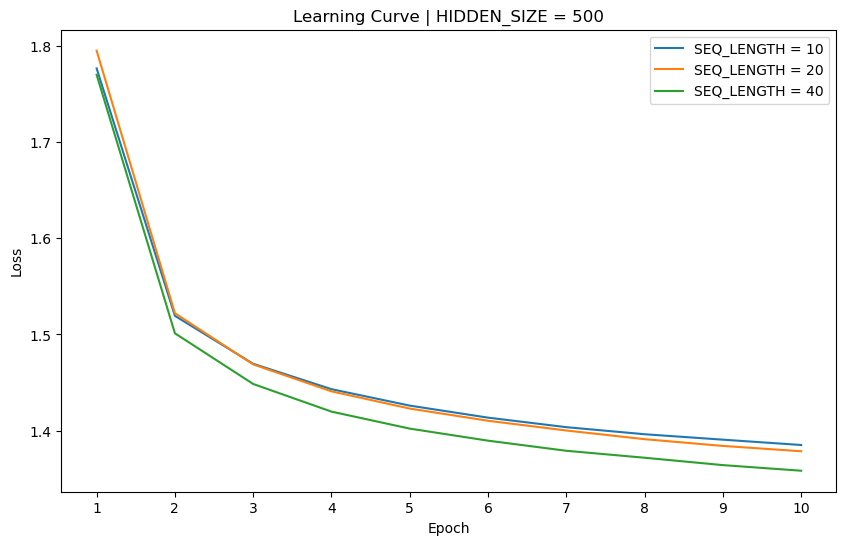

In [18]:
seq_lengths = [10, 20, 40]
results_seq_length = {}

for seq_length in seq_lengths:
    x_train, y_train = process_data(train_text, seq_length)
    x_valid, y_valid = process_data(valid_text, seq_length)
    
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, input_shape=(seq_length, vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=LEARNING_RATE))
    
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    results_seq_length[seq_length] = history.history['loss']

plt.figure(figsize=(10, 6))
for seq_length, loss in results_seq_length.items():
    plt.plot(range(1, EPOCHS + 1), loss, label=f"SEQ_LENGTH = {seq_length}")
plt.title("Learning Curve | HIDDEN_SIZE = 500")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.show()

In [12]:
#simple rnn + architecture
LEARNING_RATE=0.001
BATCH_SIZE=64

model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(SEQ_LENGTH, vocab_size)))
model.add(Dropout(0.2))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=LEARNING_RATE))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               24832     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 65)                8385      
                                                                 
 activation_1 (Activation)   (None, 65)                0         
                                                                 
Total params: 33,217
Trainable params: 33,217
Non-trainable params: 0
_________________________________________________________________


In [13]:
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                        batch_size=BATCH_SIZE, epochs=1, verbose=2)
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    if (epoch + 1) in [1, 3, 5, 7, 10]:
        print(f"\nGenerated text after epoch {epoch + 1}:")
        print(generate_text(5, temperature=0.5))

Epoch 1/10


2024-11-27 03:02:13.734251: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10938/10938 - 60s - loss: 2.2627 - val_loss: 2.1519 - 60s/epoch - 6ms/step

Generated text after epoch 1:
 wife,
Nor how to us oun bead hid singt me and of reake hich me cond couetr the tore and counther,
And may outh hen the coure soree for he sorean,
So shour arding bo pathere some thee for shall tound ard of hearthe:
Whace pordeetrot fowell courant nom the pither,

Epoch 2/10
10938/10938 - 64s - loss: 2.0712 - val_loss: 2.0579 - 64s/epoch - 6ms/step
Epoch 3/10
10938/10938 - 73s - loss: 1.9940 - val_loss: 1.9993 - 73s/epoch - 7ms/step

Generated text after epoch 3:
thou tell? for I wourd of soor gand love to the with lord.

LADY CI I He neng OLINGBROKE:
I last thou his bete of moft as the ford, the sant of mariseng shall such is the peatherse with hath thou hath a tere to make the ford, ather shall gothing the coust then, I hamp at is the gear,
And then to make the ford, his dist that lowgre come to have will sive our good be the friling ont seart.

Epoch 4/10
10938/10938 - 69s - los

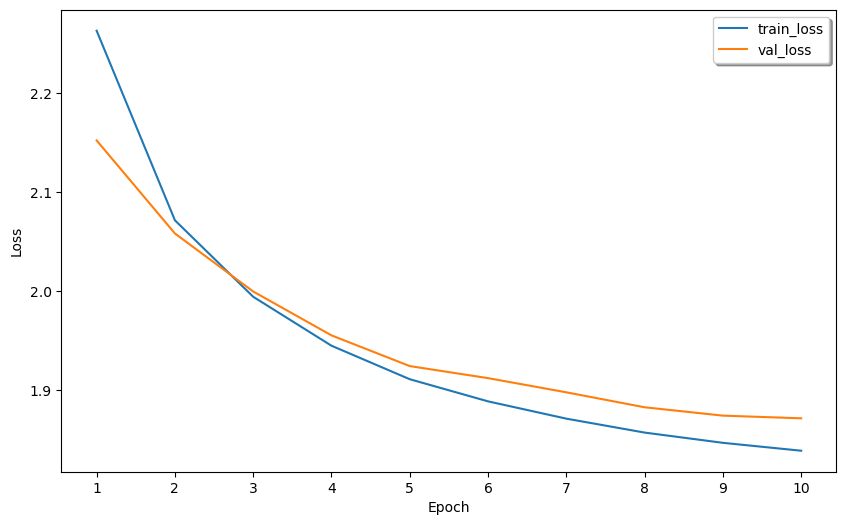

Training error rate = 
1.8384898900985718
Validation error rate = 
1.8712307214736938


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="train_loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="val_loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(range(1, len(train_loss) + 1))
plt.legend(loc='upper right', shadow=True)
plt.show()

print("Training error rate = ")
print(train_loss[-1])
print("Validation error rate = ")
print(val_loss[-1])

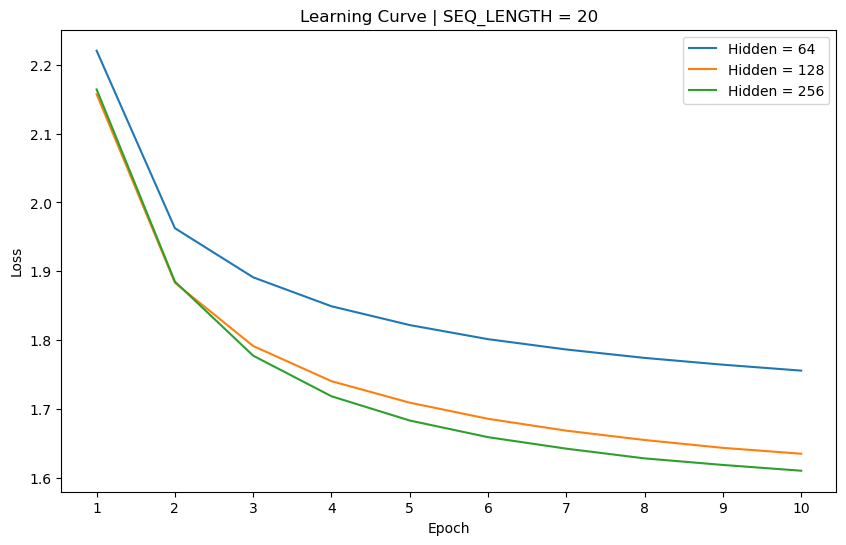

In [15]:
hidden_sizes = [64, 128, 256]
results_hidden = {}

for hidden_size in hidden_sizes:
    model = Sequential()
    model.add(SimpleRNN(hidden_size, input_shape=(SEQ_LENGTH, vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=LEARNING_RATE)
)  
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    results_hidden[hidden_size] = history.history['loss']

plt.figure(figsize=(10, 6))
for hidden_size, loss in results_hidden.items():
    plt.plot(range(1, EPOCHS + 1), loss, label=f"Hidden = {hidden_size}")
plt.title("Learning Curve | SEQ_LENGTH = 20")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.show()

/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_91269/1732760677.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, vocab_size), dtype=np.bool)
/var/folders/52/8y5ry6cn6lb3856sdgttfvl80000gn/T/ipykernel_91269/1732760677.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(senten

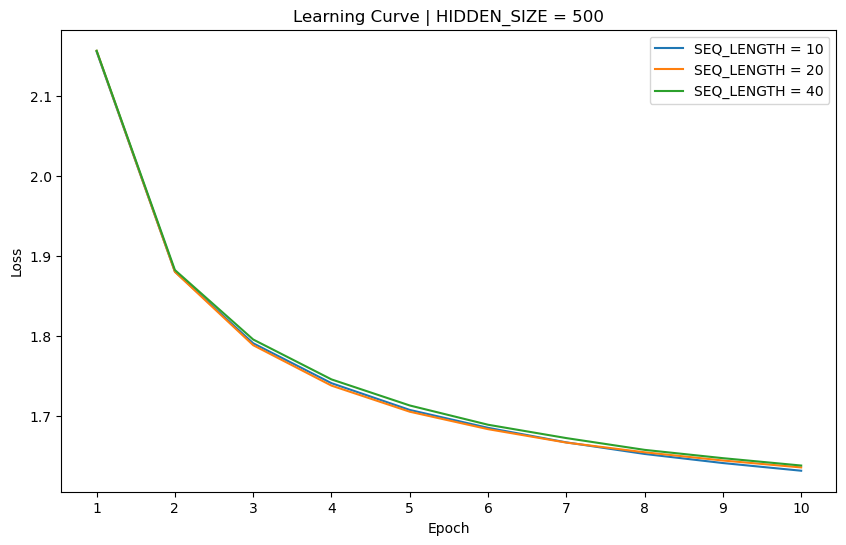

In [18]:
seq_lengths = [10, 20, 40]
results_seq_length = {}

for seq_length in seq_lengths:
    x_train, y_train = process_data(train_text, seq_length)
    x_valid, y_valid = process_data(valid_text, seq_length)
    
    model = Sequential()
    model.add(SimpleRNN(HIDDEN_SIZE, input_shape=(seq_length, vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=LEARNING_RATE))
    
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                        batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    results_seq_length[seq_length] = history.history['loss']

plt.figure(figsize=(10, 6))
for seq_length, loss in results_seq_length.items():
    plt.plot(range(1, EPOCHS + 1), loss, label=f"SEQ_LENGTH = {seq_length}")
plt.title("Learning Curve | HIDDEN_SIZE = 500")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.show()